# An analysis of an IMDb data snapshot. What films are highly viewed / rated, and what new films should I watch?

## Information about the data:

The data is taken from https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset, downloaded as csv files and uploaded to my own Postgres database. Whilst csv files could be directly accessed and manipulated via Python (Pandas), I wanted to gain experience managing and querying data in a database. The data set was up to date as of 2020, and so this analysis is a reflection of the data at that time.

Whilst the full data set contains all movies listed on IMDb, my queries will more than likely only consist of movies where English is a listed language and where there are more than 5000 recorded votes. I understand there is some bias to these restrictions, but my reasoning is as follows. To the former point, I am an English speaker and am primarily interested in English spoken movies. This is not always the case, but upon querying the database there were far too many non-English spoken films, and this did not benefit me in my aims for this analysis. To the latter point, movie ratings were heavily skewed by a lack of votes. The average vote count across all movies was just over 9000. I understand that newer movies are heavily discriminated by using this metric, but it was more beneficial overall. I settled on including all movies that had at least 5000 votes.

## What this notebook is:

This notebook contains an exploratory analysis into what films are popular. It will also serve as a means for me to find new films to watch, by querying the data set for the common features amongst the films I currently enjoy. By this analysis, I hope to gain a better understanding into why films are popular / highly rated, as well as finding 'hidden gems' that appeal to my tastes.

## Code imports and helper function for querying the database:

In [24]:
import psycopg2
import pandas as pd
import matplotlib as plt
import seaborn as sns
import configparser

# read database parameters from a config file
try:
    config = configparser.ConfigParser()
    config.read('config.ini')
    params = dict(config['DEFAULT'])
except:
    print('No config.ini file found.')

In [3]:
def query_db(query, params):
    '''Execute SQL queries passed to this function and return query results as data frame'''
    
    conn = None
    try:
        conn = psycopg2.connect(**params)
        df = pd.read_sql_query(query, conn)
        conn.close()
        return(df)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()

## Analysis:

__*Where to start?*__
<br>Lets first take a look at the 10 highest rated films as a starting point.

In [4]:
# The top 10 highest rated films with restrictions
top_10_query = '''
    select original_title, year, genre, duration, avg_vote, votes
    from movies
    where language like '%English%' and votes > 5000
    order by avg_vote desc
    limit 10;
'''

df_top_10 = query_db(top_10_query, params)
df_top_10

,original_title,year,genre,duration,avg_vote,votes
0,The Shawshank Redemption,1994,Drama,142,9.3,2278845
1,The Godfather,1972,"Crime, Drama",175,9.2,1572674
2,The Godfather: Part II,1974,"Crime, Drama",202,9.0,1098714
3,The Dark Knight,2008,"Action, Crime, Drama",152,9.0,2241615
4,12 Angry Men,1957,"Crime, Drama",96,8.9,668473
5,Pulp Fiction,1994,"Crime, Drama",154,8.9,1780147
6,Schindler's List,1993,"Biography, Drama, History",195,8.9,1183248
7,The Lord of the Rings: The Return of the King,2003,"Action, Adventure, Drama",201,8.9,1604280
8,The Lord of the Rings: The Fellowship of the Ring,2001,"Action, Adventure, Drama",178,8.8,1619920
9,Forrest Gump,1994,"Drama, Romance",142,8.8,1755490


In [56]:
# Average rating across all films with restrictions
avg_rat_query = '''
    select avg(avg_vote) as avg_vote
    from movies
    where language like '%English%' and votes > 5000
'''

# adding original_title field to result for later joining with other df
df_avg_rat = query_db(avg_rat_query, params)
df_avg_rat['original_title'] = 'Average Film Rating (All Films)'
df_avg_rat

,avg_vote,original_title
0,6.461674,Average Film Rating (All Films)


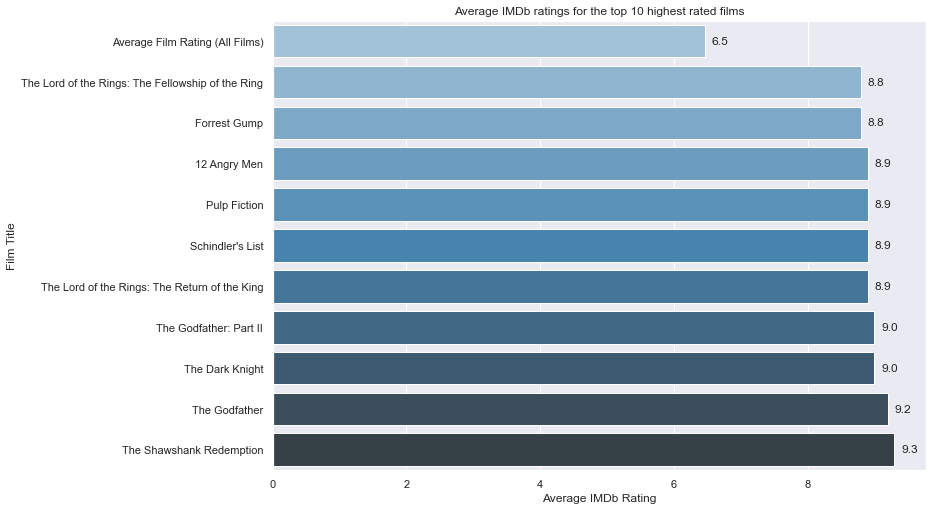

In [57]:
# join avg film rating to top 10 ratings and display as bar chart
df_rat_graph = df_top_10[['original_title', 'avg_vote']]
df_rat_graph = df_rat_graph.append(df_avg_rat, ignore_index=True)
df_rat_graph = df_rat_graph.sort_values(by=['avg_vote'])

sns.set_theme(style='whitegrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(data=df_rat_graph, y='original_title', x='avg_vote', palette='Blues_d')
for p in ax.patches:
    height = p.get_height() # height of each horizontal bar is the same
    width = p.get_width() # width (average number of passengers)
    # adding text to each bar
    ax.text(x = width+0.1, # x-coordinate position of data label, padded 3 to right of bar
    y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
    s = '{:.1f}'.format(width), # data label, formatted to ignore decimals
    va = 'center') # sets vertical alignment (va) to center
ax.set(ylabel='Film Title', xlabel='Average IMDb Rating', title='Average IMDb ratings for the top 10 highest rated films');

In [ ]:
# this is a bad query as it takes only the first genre in the string, genres are listed alphabetically so that genres such as drama are over represented. Need to find a way to include every film in every
# group by for each genre it is.
bad_query = '''
    select substring(genre from '^[a-zA-Z]+'), count(*) as num_films_in_genre, avg(avg_vote) as avg_vote_of_genre
    from movies
    where language like '%English%' and votes > 5000
    group by substring(genre from '^[a-zA-Z]+')
    having count(*) > 10
    order by avg(avg_vote) desc
    limit 10;
'''